In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,RandomizedSearchCV
from sklearn.metrics import f1_score,classification_report,confusion_matrix,accuracy_score,roc_curve,auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,VotingClassifier
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder,StandardScaler
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import data
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

print(train.shape)
print(test.shape)


(150000, 9)
(50000, 8)


In [3]:
train.head()


,ID,STATE,AGE,OCCUPATION,INCOME_GROUP,CUSTOMER_SINCE,LOYALTY_PROGRAM,PAST_PURCHASE,PURCHASE
0,1,Uttar Pradesh,28,,Low,2018,No,4937,No
1,2,Madhya Pradesh,27,Salaried,Low,2018,No,10834,No
2,3,West Bengal,62,,High,2013,NaN,8610,Yes
3,4,Tamil Nadu,27,Salaried,Low,2018,No,14374,Yes
4,5,Uttar Pradesh,40,Self employed,High,2015,No,13158,No


In [4]:
test.head()


,ID,STATE,AGE,OCCUPATION,INCOME_GROUP,CUSTOMER_SINCE,LOYALTY_PROGRAM,PAST_PURCHASE
0,150001,Maharashtra,50,Self employed,Medium,2018,No,12746
1,150002,Maharashtra,58,Self employed,High,2011,Yes,12277
2,150003,Andaman and Nicobar Islands,30,Salaried,Low,2017,Yes,16401
3,150004,Mizoram,27,Salaried,Low,2018,Yes,9665
4,150005,Uttar Pradesh,67,,Medium,2014,No,15724


In [5]:
# removing unwanted columns
train.drop('ID',axis=1,inplace=True)
test.drop('ID',axis=1,inplace=True)


In [6]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   STATE            150000 non-null  object
 1   AGE              150000 non-null  int64 
 2   OCCUPATION       150000 non-null  object
 3   INCOME_GROUP     150000 non-null  object
 4   CUSTOMER_SINCE   150000 non-null  int64 
 5   LOYALTY_PROGRAM  132176 non-null  object
 6   PAST_PURCHASE    150000 non-null  int64 
 7   PURCHASE         150000 non-null  object
dtypes: int64(3), object(5)
memory usage: 9.2+ MB


In [7]:
train.describe()


,AGE,CUSTOMER_SINCE,PAST_PURCHASE
count,150000.000000,150000.000000,150000.000000
mean,43.805660,2015.507960,11244.207287
std,14.828219,2.685645,8458.166886
min,23.000000,2008.000000,208.000000
25%,30.000000,2013.000000,6034.750000
50%,43.000000,2017.000000,8926.000000
75%,54.000000,2018.000000,13636.000000
max,85.000000,2019.000000,103520.000000


In [8]:
# Column LOYALTY_PROGRAM has some null values
# we observe that there are 3 numeric columns out of which CUSTOMER_SINCE
# is numeric categorical


No     114537
Yes     35463
Name: PURCHASE, dtype: int64


<AxesSubplot:xlabel='PURCHASE', ylabel='count'>

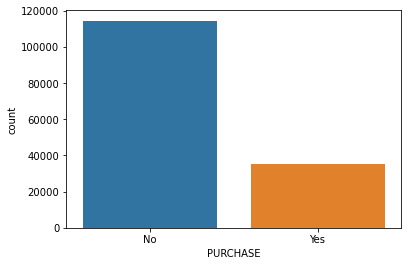

In [9]:
# checking for distribution of target column
print(train.PURCHASE.value_counts())
sns.countplot(x=train.PURCHASE)


 we observe that data is imbalanced with No purchase greater than 3 times as purchased

In [10]:
# checking for null values
print(train.isnull().sum())
print()
print(test.isnull().sum())


STATE                  0
AGE                    0
OCCUPATION             0
INCOME_GROUP           0
CUSTOMER_SINCE         0
LOYALTY_PROGRAM    17824
PAST_PURCHASE          0
PURCHASE               0
dtype: int64

STATE                 0
AGE                   0
OCCUPATION            0
INCOME_GROUP          0
CUSTOMER_SINCE        0
LOYALTY_PROGRAM    6004
PAST_PURCHASE         0
dtype: int64


In [11]:
# printing % null values
print(round(train.isnull().sum()/train.isnull().count()*100,2))
print()
print(round(test.isnull().sum()/test.isnull().count()*100,2))


STATE               0.00
AGE                 0.00
OCCUPATION          0.00
INCOME_GROUP        0.00
CUSTOMER_SINCE      0.00
LOYALTY_PROGRAM    11.88
PAST_PURCHASE       0.00
PURCHASE            0.00
dtype: float64

STATE               0.00
AGE                 0.00
OCCUPATION          0.00
INCOME_GROUP        0.00
CUSTOMER_SINCE      0.00
LOYALTY_PROGRAM    12.01
PAST_PURCHASE       0.00
dtype: float64


<AxesSubplot:xlabel='LOYALTY_PROGRAM'>

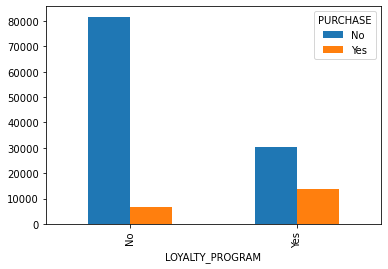

In [12]:
# since LOYALTY_PROGRAM has null values let's check if it has a relation with target

pd.crosstab(train.LOYALTY_PROGRAM,train.PURCHASE).plot(kind='bar')


 we observe that people who have loyalty program have purchased
 more no. of times than people who do not have loyalty program

In [13]:
# Since we do not know if the missing LOYALTY_PROGRAM people 
# have purchased or not we impute it with N.A

train.LOYALTY_PROGRAM.fillna('N.A',inplace=True)
test.LOYALTY_PROGRAM.fillna('N.A',inplace=True)
train.isnull().sum()



STATE              0
AGE                0
OCCUPATION         0
INCOME_GROUP       0
CUSTOMER_SINCE     0
LOYALTY_PROGRAM    0
PAST_PURCHASE      0
PURCHASE           0
dtype: int64

Maharashtra                    21968
Tamil Nadu                     17836
Uttar Pradesh                  16400
Karnataka                      11689
Gujarat                         7864
West Bengal                     7751
Telangana                       4783
Andhra Pradesh                  4781
Rajasthan                       4621
Kerala                          3718
Madhya Pradesh                  3680
Delhi                           3572
Bihar                           3225
Haryana                         3197
Punjab                          3113
Odisha                          2773
Assam                           2638
Chhattisgarh                    2366
Jharkhand                       2242
Uttarakhand                     1984
Jammu and Kashmir               1962
                                1842
Himachal Pradesh                1763
Goa                             1735
Tripura                         1735
Chandigarh                      1583
Puducherry                      1503
M

<AxesSubplot:xlabel='STATE'>

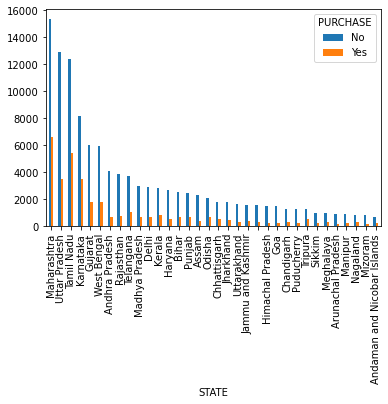

In [14]:
# Exploratory data analysis
# Categorical columns
# STATE
print(train.STATE.value_counts())

tab=pd.crosstab(train.STATE,train.PURCHASE).sort_values('No',ascending=False)
tab.plot(kind='bar')


 from above graph we observe that Maximum customers are from
 Maharashtra, Uttar Prades, Tamil Nadu and Karnataka
 Also maximum purchase have beem made from Maharashtra,
 Uttar Prades, Tamil Nadu and Karnataka

<AxesSubplot:xlabel='OCCUPATION'>

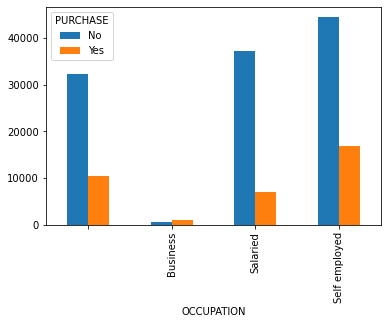

In [15]:
# OCCUPATION
pd.crosstab(train.OCCUPATION,train.PURCHASE).plot(kind='bar')


 Maximum customers are from Self employed category who have also
 made maximum purchases.
 Business category people have made the least purchase

<AxesSubplot:xlabel='INCOME_GROUP'>

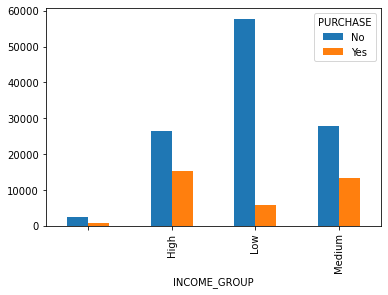

In [16]:
# INCOME_GROUP
pd.crosstab(train.INCOME_GROUP,train.PURCHASE).plot(kind='bar')


 People with low income has made the least purchase
 People with high income has made the most purchase

<AxesSubplot:xlabel='CUSTOMER_SINCE'>

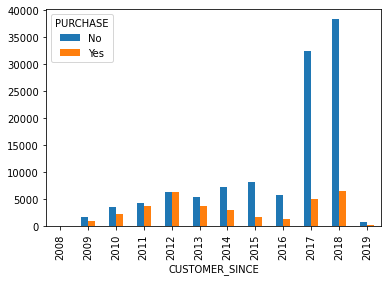

In [17]:
pd.crosstab(train.CUSTOMER_SINCE,train.PURCHASE).plot(kind='bar')


 maximum purchases have been made from people who have been customers
 since 2012

<AxesSubplot:xlabel='AGE'>

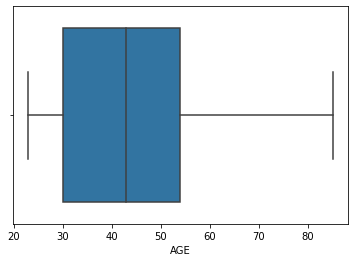

In [18]:
# Numeric Columns
# Age
# checking for outliers
sns.boxplot(train.AGE)


 we observe that there are no outliers

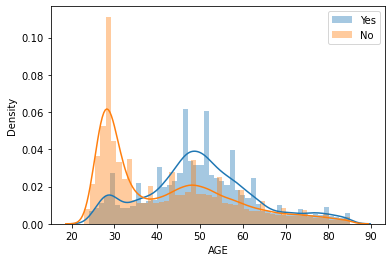

In [19]:
# age distrubution
sns.distplot(train.AGE[train.PURCHASE=='Yes'],label='Yes')
sns.distplot(train.AGE[train.PURCHASE=='No'],label='No')
plt.legend()


 maximum purchase have been made in the age group around 50 years
 mimimum pruchase has been made in age group around 30 years

<AxesSubplot:xlabel='INCOME_GROUP', ylabel='AGE'>

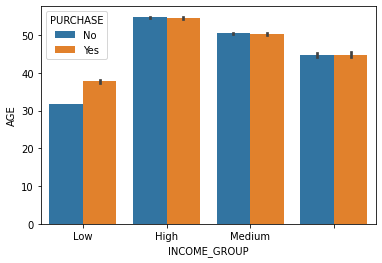

In [20]:
sns.barplot(x='INCOME_GROUP',y='AGE',data=train,hue='PURCHASE')


 from above distplot and barplot we can conclude that
 people from High income category were around age of 50. Therefore they made more purchases.
 Also we can observe that people from low income group were around the
 age of thirties and therefore they made less purhcases

6034.75
13636.0


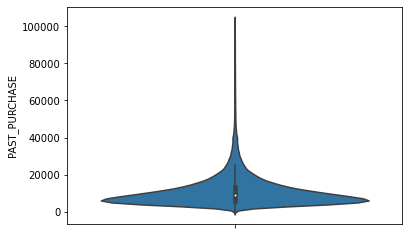

In [21]:
# PAST_PURCHASE
# distribution
sns.violinplot(y=train.PAST_PURCHASE)
print(train.PAST_PURCHASE.quantile(0.25))
print(train.PAST_PURCHASE.quantile(0.75))

In [22]:
# we see that maximum purchases(50%) have been in the range of
# 6000 Rs to 13500 Rs.


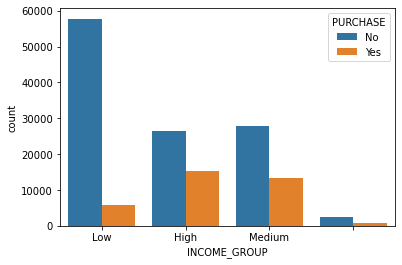

<AxesSubplot:xlabel='INCOME_GROUP', ylabel='PAST_PURCHASE'>

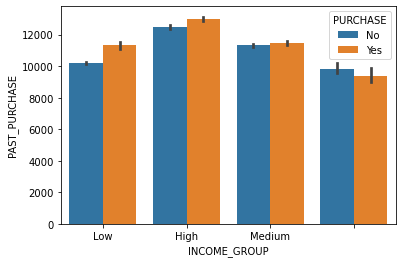

In [23]:
sns.countplot(x='INCOME_GROUP',data=train,hue='PURCHASE')
plt.show()
sns.barplot(x='INCOME_GROUP',y='PAST_PURCHASE',data=train,hue='PURCHASE')


 from above plots we observe that high income group has purchased
 more number of times and of more value

In [24]:
# separating target variable
target=train.pop('PURCHASE')
num=['AGE','PAST_PURCHASE']
cat=['STATE','OCCUPATION', 'INCOME_GROUP', 'CUSTOMER_SINCE','LOYALTY_PROGRAM']


In [25]:
# label encoding categorical values
le=LabelEncoder()
train[cat]=train[cat].apply(le.fit_transform)
train


,STATE,AGE,OCCUPATION,INCOME_GROUP,CUSTOMER_SINCE,LOYALTY_PROGRAM,PAST_PURCHASE
0,31,28,0,2,10,1,4937
1,17,27,2,2,10,1,10834
2,33,62,0,1,5,0,8610
3,28,27,2,2,10,1,14374
4,31,40,3,1,7,1,13158
...,...,...,...,...,...,...,...
149995,4,29,2,2,9,1,6241
149996,2,53,3,3,2,1,29447
149997,23,31,0,2,10,1,4856
149998,2,54,3,1,2,2,10031


In [26]:
test[cat]=test[cat].apply(le.fit_transform)
test


,STATE,AGE,OCCUPATION,INCOME_GROUP,CUSTOMER_SINCE,LOYALTY_PROGRAM,PAST_PURCHASE
0,18,50,3,3,10,1,12746
1,18,58,3,1,3,2,12277
2,1,30,2,2,9,2,16401
3,21,27,2,2,10,2,9665
4,31,67,0,3,6,1,15724
...,...,...,...,...,...,...,...
49995,15,49,3,3,8,1,15751
49996,16,47,3,1,8,0,7114
49997,18,63,0,1,3,1,16022
49998,26,32,2,2,9,2,6239


In [27]:
target=le.fit_transform(target)
target


array([0, 0, 1, ..., 0, 1, 1])

In [28]:
# No->0
# Yes->1

In [29]:
# splitting into train and validation
trainx,validationx,trainy,validationy=train_test_split(train,target,test_size=0.2)
print(trainx.shape)
print(validationx.shape)
print(trainy.shape)
print(validationy.shape)


(120000, 7)
(30000, 7)
(120000,)
(30000,)


In [30]:
# scaling numerical values
sc=StandardScaler()
trainx[num]=sc.fit_transform(trainx[num])
validationx[num]=sc.transform(validationx[num])
test[num]=sc.transform(test[num])



 Fitting the model
 we first define models which cross validate and give the best model

In [31]:
# Random Forest model
def rf_cross_val(trainx, trainy):
    # using cross validation
    n_estimators = [10,25, 50, 75, 100, 150, 200]
    criterion = ['gini', 'entropy']
    min_samples_leaf = np.arange(10,40,10)
    min_samples_split = np.arange(2,15,5)
    grid = {'n_estimators': n_estimators, 'criterion': criterion,
            'min_samples_leaf': min_samples_leaf, 'min_samples_split': min_samples_split}

    cross_val = RandomizedSearchCV(RandomForestClassifier(), grid, cv=3,
                                   scoring='f1_micro',return_train_score=True).fit(trainx, trainy)
    best_params = cross_val.best_params_
    print('Random Forest cv score',cross_val.best_score_)
    rf = RandomForestClassifier(n_estimators=best_params['n_estimators'],
                                min_samples_split=best_params['min_samples_split'],
                                min_samples_leaf=best_params['min_samples_leaf'],
                                criterion=best_params['criterion']).fit(trainx, trainy)
    return rf


In [32]:

def dt_cross_val(trainx, trainy):
    # using cross validation
    criterion = ['gini', 'entropy']
    splitter = ['best', 'random']
    min_samples_leaf = np.arange(10,40,10)
    min_samples_split = np.arange(2,15,5)
    ccp_alpha = [0, 0.01, 0.025, 0.05, 0.1]
    grid = {'splitter': splitter, 'criterion': criterion,
            'min_samples_leaf': min_samples_leaf, 'min_samples_split': min_samples_split,
            'ccp_alpha': ccp_alpha}

    cross_val = RandomizedSearchCV(DecisionTreeClassifier(), grid, cv=3,
                                   scoring='f1_micro',return_train_score=True).fit(trainx, trainy)
    best_params = cross_val.best_params_
    print('Decision Tree cv score',cross_val.best_score_)
    df = DecisionTreeClassifier(splitter=best_params['splitter'],
                                min_samples_split=best_params['min_samples_split'],
                                min_samples_leaf=best_params['min_samples_leaf'],
                                criterion=best_params['criterion'],
                                ccp_alpha=best_params['ccp_alpha']).fit(trainx, trainy)
    return df


In [33]:
def knn_cross_val(trainx, trainy):
    # using cross validation
    n_neighbors = range(3, 12, 2)
    weights = ['uniform', 'distance']
    grid = {'n_neighbors': n_neighbors, 'weights': weights}

    cross_val = RandomizedSearchCV(KNeighborsClassifier(), grid, cv=3,
                                   scoring='f1_micro',return_train_score=True).fit(trainx, trainy)
    best_params = cross_val.best_params_
    print('KNN cv score',cross_val.best_score_)
    knn = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'],
                               weights=best_params['weights']).fit(trainx, trainy)
    return knn


In [34]:

def svm_cross_val(trainx, trainy):
    # using cross validation
    C = [ 0.1, 0.25, 0.5, 1]
    penalty = ['l1', 'l2']
    loss = ['hinged', 'squared_hinge']
    grid = {'penalty': penalty, 'C': C,
            'loss': loss}

    cross_val = RandomizedSearchCV(svm.LinearSVC(), grid, cv=3,
                                   scoring='f1_micro',return_train_score=True).fit(trainx, trainy)
    best_params = cross_val.best_params_
    print('SVM cv score',cross_val.best_score_)
    svc = svm.LinearSVC(penalty=best_params['penalty'],
                        C=best_params['C'],
                        loss=best_params['loss']).fit(trainx, trainy)
    return svc


In [35]:

def ada_cross_val(trainx, trainy):
    # using cross validation
    base_estimator = [DecisionTreeClassifier(
        max_depth=1)]
    learning_rate = [0.01, 0.05, 0.1, 0.5, 1]

    grid = {'base_estimator': base_estimator,'learning_rate': learning_rate}

    cross_val = RandomizedSearchCV(AdaBoostClassifier(), grid, cv=3,
                                   scoring='f1_micro',return_train_score=True).fit(trainx, trainy)
    
    best_params = cross_val.best_params_
    print('Adaboost cv score',cross_val.best_score_)
    ada = AdaBoostClassifier(base_estimator=best_params['base_estimator'],
                             learning_rate=best_params['learning_rate']).fit(trainx, trainy)
    return ada


In [36]:

def gradient_cross_val(trainx, trainy):
    # using cross validation
    min_samples_leaf = np.arange(10,40,10)
    min_samples_split = np.arange(2,15,5)
    grid = {'min_samples_leaf': min_samples_leaf, 'min_samples_split': min_samples_split}

    cross_val = RandomizedSearchCV(GradientBoostingClassifier(), grid, cv=3,
                                   scoring='f1_micro',return_train_score=True).fit(trainx, trainy)
    best_params = cross_val.best_params_
    print('Gradient Boost cv score',cross_val.best_score_)
    gradient = GradientBoostingClassifier(min_samples_split=best_params['min_samples_split'],
                                          min_samples_leaf=best_params['min_samples_leaf'],).fit(trainx, trainy)
    return gradient


def run_model(trainx, trainy):

    # decision Tree Model
    model_dt = dt_cross_val(trainx, trainy)

    # Random forest Model
    model_rf = rf_cross_val(trainx, trainy)
    # knn forest Model
    model_knn = knn_cross_val(trainx, trainy)
    # svm Model
    model_svm = svm_cross_val(trainx, trainy)
    # gradient boost Model
    model_gradient = gradient_cross_val(trainx, trainy)
    # Adaboost Model
    # using 1 features i.e 1 stump for Adaboost

    model_ada = ada_cross_val(trainx, trainy)

    # XGBoost Model
    model_xgb = xgb.XGBClassifier(n_estimators=100).fit(trainx, trainy)
    model_vc = VotingClassifier(estimators=[('dt', model_dt), ('rf', model_rf),
                                            ('knn', model_knn), ('svm', model_svm),
                                            ('gradient',
                                             model_gradient), ('ada', model_ada),
                                            ('xgb', model_xgb)], voting='hard').fit(trainx, trainy)
    
    return [model_dt, model_rf, model_knn, model_svm, model_gradient, model_ada, model_xgb, model_vc]



In [37]:

# building funtion to plot ROC AUC curve and get metrics
def get_results(model, testx, testy):
    # unpacking the models
    model_dt, model_rf, model_knn, model_svm, model_gradient, model_ada, model_xgb, model_vc = model

    # predicting the values
    p_dt = model_dt.predict(testx)
    p_rf = model_rf.predict(testx)
    p_knn = model_knn.predict(testx)
    p_svm = model_svm.predict(testx)
    p_gradient = model_gradient.predict(testx)
    p_ada = model_ada.predict(testx)
    p_xgb = model_xgb.predict(testx)
    p_vc = model_vc.predict(testx)

    # creating lists to store result
    model_name = np.array(['Decision Tree', 'Random Forest', 'knn',
                           'svm', 'Gradientb', 'Adaboost', 'XGBoost', 'Voting'])

    accuracy = np.round(np.array([accuracy_score(testy, p_dt), accuracy_score(testy, p_rf),
                                  accuracy_score(testy, p_knn), accuracy_score(testy, p_svm),
                                  accuracy_score(testy, p_gradient), accuracy_score(testy, p_ada),
                                  accuracy_score(testy, p_xgb),accuracy_score(testy, p_vc)]), 2)

    f1score = np.round(np.array([f1_score(testy, p_dt), f1_score(testy, p_rf),
                                 f1_score(testy, p_knn), f1_score(testy, p_svm),
                                 f1_score(testy, p_gradient),f1_score(testy, p_ada),
                                 f1_score(testy, p_xgb),f1_score(testy, p_vc)]), 2)

    # unpacking fpr,tpr
    fpr_dt, tpr_dt, thres_dt = roc_curve(testy, p_dt)
    fpr_rf, tpr_rf, thres_rd = roc_curve(testy, p_rf)
    fpr_knn, tpr_knn, thres_rd = roc_curve(testy, p_knn)
    fpr_svm, tpr_svm, thres_rd = roc_curve(testy, p_svm)
    fpr_gradient, tpr_gradient, thres_ada = roc_curve(testy, p_gradient)
    fpr_ada, tpr_ada, thres_rd = roc_curve(testy, p_ada)
    fpr_xgb, tpr_xgb, thres_xgb = roc_curve(testy, p_xgb)
    fpr_vc, tpr_vc, thres_xgb = roc_curve(testy, p_vc)

    # getting auc
    auc_dt = np.round(auc(fpr_dt, tpr_dt), 2)
    auc_rf = np.round(auc(fpr_rf, tpr_rf), 2)
    auc_knn = np.round(auc(fpr_knn, tpr_knn), 2)
    auc_svm = np.round(auc(fpr_svm, tpr_svm), 2)
    auc_gradient = np.round(auc(fpr_gradient, tpr_gradient), 2)
    auc_ada = np.round(auc(fpr_ada, tpr_ada), 2)
    auc_xgb = np.round(auc(fpr_xgb, tpr_xgb), 2)
    auc_vc = np.round(auc(fpr_vc, tpr_vc), 2)
    roc_auc = np.array([auc_dt, auc_rf, auc_knn,auc_svm, auc_gradient, auc_ada, auc_xgb,auc_vc])

    # getting the tpr for roc_curve which is sensitivity
    sensitivity = np.round(np.array([tpr_dt[1], tpr_rf[1], tpr_knn[1], tpr_svm[1],
                             tpr_gradient[1], tpr_ada[1], tpr_xgb[1],tpr_vc[1]]), 2)
    # getting the fpr and subtracting from 1 to get specificity
    specificity = np.round(np.array([1-fpr_dt[1], 1-fpr_rf[1], 1-fpr_knn[1], 1-fpr_svm[1],
                             1-fpr_gradient[1], 1-fpr_ada[1], 1-fpr_xgb[1],1-fpr_vc[1]]), 2)
    results = pd.DataFrame({'model': model_name, 'accuracy': accuracy, 'f1_score': f1score,
                            'sensitivity': sensitivity, 'specificity': specificity, 'ROC': roc_auc})

    # plotting ROC AUC
    plt.figure(figsize=(15, 7))
    plt.plot(fpr_dt, tpr_dt, label='Decision Tree AUC: %0.2f' % auc_dt)
    plt.plot(fpr_rf, tpr_rf, label='Random Forest AUC: %0.2f' % auc_rf)
    plt.plot(fpr_knn, tpr_knn, label='knn AUC: %0.2f' % auc_knn)
    plt.plot(fpr_svm, tpr_svm, label='svm AUC: %0.2f' % auc_svm)
    plt.plot(fpr_gradient, tpr_gradient,label='Gradient AUC: %0.2f' % auc_gradient)
    plt.plot(fpr_ada, tpr_ada, label='AdaBoost AUC: %0.2f' % auc_ada)
    plt.plot(fpr_xgb, tpr_xgb, label='XGBoost AUC: %0.2f' % auc_xgb)
    plt.plot(fpr_vc, tpr_vc, label='Voting AUC: %0.2f' % auc_vc)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC curve')
    plt.legend()
    plt.show()

    return results


In [41]:
# creating submission file
def create_submission(predict, filename):
    d = {'ID': np.arange(150001, 150001+len(test)), 'PURCHASE': predict}
    submission = pd.DataFrame(d)
    submission.PURCHASE.replace(1, 'Yes', inplace=True)
    submission.PURCHASE.replace(0, 'No', inplace=True)
    submission.to_csv(filename, index=False)


In [42]:
# running models and getting cross validation score
model=  run_model(trainx, trainy)


Decision Tree cv score 0.8520416666666667
Random Forest cv score 0.8571
KNN cv score 0.8339916666666666
SVM cv score 0.79285
Gradient Boost cv score 0.8581666666666666
Adaboost cv score 0.85485
[23:15:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


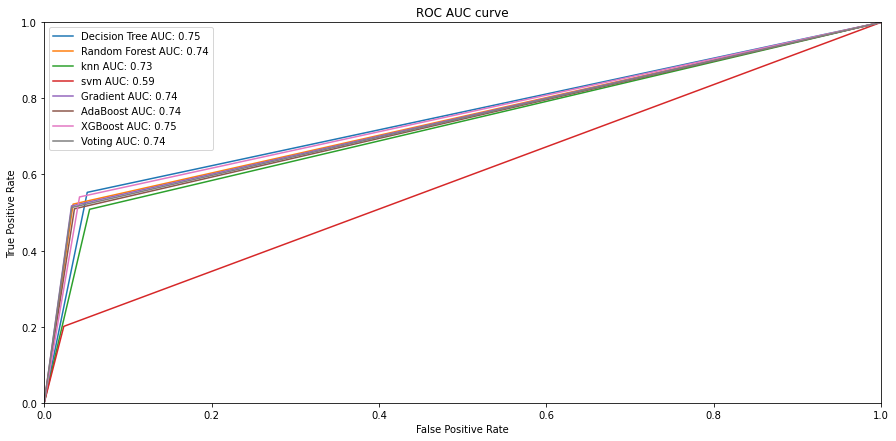

In [43]:
# plotting ROC AUC
result=get_results(model, validationx, validationy)

In [44]:
# comparing results
result

,model,accuracy,f1_score,sensitivity,specificity,ROC
0,Decision Tree,0.85,0.64,0.55,0.95,0.75
1,Random Forest,0.86,0.64,0.52,0.97,0.74
2,knn,0.84,0.60,0.51,0.95,0.73
3,svm,0.79,0.31,0.20,0.98,0.59
4,Gradientb,0.86,0.64,0.52,0.97,0.74
5,Adaboost,0.86,0.63,0.51,0.96,0.74
6,XGBoost,0.86,0.65,0.54,0.96,0.75
7,Voting,0.86,0.63,0.51,0.97,0.74


In [45]:
# we see that random forest classifier gives us the best result
best_model=model[1]


In [46]:
# getting parameters for best_model
best_model.get_params


<bound method BaseEstimator.get_params of RandomForestClassifier(criterion='entropy', min_samples_leaf=30,
                       min_samples_split=7, n_estimators=150)>

In [47]:
# gettting predictions for test data
prediction=best_model.predict(test)
prediction

array([0, 0, 0, ..., 0, 0, 0])

In [48]:
# saving predictions
create_submission(prediction, 'submission_01.csv')